## From https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467576

# CatBoost Starter for Brain Comp
This is a CatBoost starter notebook for Kaggle's brain comp. We use only spectrogram features. (The model does not use eeg features yet). We can improve the CV and LB score by engineering more (spectrogram and/or eeg) features and we can tune the CatBoost model (and/or use other ML DL models). Discussion about this starter is [here][2].

In this notebook, we also compare four CV scores. Kaggle's sample submission uses equal predictions of 1/6 for all targets and achieves CV 1.46, LB 1.09. The best public notebook (on Jan 12th) [here][1] uses train means and achieves CV 1.26 LB 0.97. Our CatBoost model version 1 achieves CV 1.01 LB 0.81. Our CatBoost model version 2 achieves CV 0.82. Let's submit version 2 and see what the LB score is!

### Version Notes
* Version 1 - Uses spectrogram features from 10 minute window `means`. Achieves CV 1.01, LB 0.81
* Version 2 - Uses spectrogram features from 10 minute and 20 second `means` and `mins`. Achieves CV 0.82, LB to be determined...

[1]: https://www.kaggle.com/code/seshurajup/eda-train-csv
[2]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467576


# Load Libraries

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0 , 1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, KFold
import warnings
import catboost as cat
import gc
from catboost import CatBoostClassifier, Pool
import sys
from kaggle_kl_div import score

VER = 2

# Load Train Data

In [28]:
DATA_IN = '../data/in/dataset/'
DATA_MEM = '../data/mem/'
DATA_OUT = '../data/out/'
df = pd.read_csv(f'{DATA_IN}train.csv')
TARGETS = df.columns[-6:]
print('Train shape: ', df.shape)
print('Targets', list(TARGETS))
df.head()

Train shape:  (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# Create Non-Overlapping Eeg Id Train Data
The competition data description says that test data does not have multiple crops from the same `eeg_id`. Therefore we will train and validate using only 1 crop per `eeg_id`. There is a discussion about this [here][1].

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [5]:
train = df.groupby('eeg_id')[['spectrogram_id', 'spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id': 'first', 'spectrogram_label_offset_seconds': 'min'})
train.columns = ['spec_id', 'min']

tmp = df.groupby('eeg_id')[['spectrogram_id', 'spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds': 'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values

y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1, keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape: ', train.shape)
train.head()

Train non-overlapp eeg_id shape:  (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


# Feature Engineer
In this section, we create features for our CatBoost model. 

First we need to read in all 11k train spectrogram files. Reading thousands of files takes 11 minutes with Pandas. Instead, we can read 1 file from my [Kaggle dataset here][1] which contains all the 11k spectrograms in less than 1 minute! To use my [Kaggle dataset][1], set variable `READ_SPEC_FILES = False`. Don't forget to upvote this helpful [dataset][1] :-)

Next we need to engineer features for our CatBoost model. In this notebook, we just take the mean (over time) of each of the 400 spectrogram frequencies (using middle 10 minutes). This produces 400 features (per each unique eeg id). We can improve CV and LB score by engineering new features (and/or tuning CatBoost).

UPDATE: Version 2 creates features from `means` and `mins`. And version 2 uses `10 minute windows` and `20 second windows`.

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms

In [13]:
READ_SPEC_FILES = True
FEATURE_ENGINEER = True

In [14]:
%%time
# READ ALL SPECTROGRAMS
PATH = f'{DATA_IN}train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i , f in enumerate(files):
        if i%100==0: print(i , ', ' , end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[: , 1:].values
else:
    pass
    # spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy' , allow_pickle=True).item()

There are 11138 spectrogram parquets
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , CPU times: user 3min 45s, sys: 1min 56s, total: 5min 41s
Wall time: 8min 21s


In [15]:
%time
# ENGINEER FEATURES

warnings.filterwarnings('ignore')

# FEATURE NAMES
SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ', end='')

if FEATURE_ENGINEER:
    data = np.zeros((len(train), len(FEATURES)))
    for k in range(len(train)):
        if k % 100 == 0:
            print(k, ', ', end='')
        row = train.iloc[k]
        r = int((row['min'] + row['max'])//4)

        # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r: r+300, :], axis=0)
        data[k, :400] = x
        x = np.nanmin(spectrograms[row.spec_id][r: r+300, :], axis=0)
        data[k, 400: 800] = x

        # 20 SECOND WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r+145:r+155, :], axis=0)
        data[k, 800: 1200] = x
        x = np.nanmin(spectrograms[row.spec_id][r+145:r+155, :], axis=0)
        data[k, 1200: 1600] = x

    train[FEATURES] = data
else:
    # train = pd.read_parquet('/kaggle/input/brain-spectrograms/train.pqt')
print()
print('New train shape: ', train.shape)

CPU times: user 0 ns, sys: 16 µs, total: 16 µs
Wall time: 47.4 µs
We are creating 1600 features for 17089 rows... 0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 

# Train CatBoost
We use the default settings for CatBoost which are pretty good. We can tune CatBoost manually to improve CV and LB score. Note that CatBoost will automatically use both Kaggle T4 GPUs (when we add parameter `task_type='GPU'`)  for super fast training!

In [16]:

print('CatBoost version', cat.__version__)

CatBoost version 1.2.2


In [17]:

type(KFold)
all_oof = []
all_true = []
TARS = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):

    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)

    model = CatBoostClassifier(task_type='GPU',
                               loss_function='MultiClass')

    train_pool = Pool(data=train.loc[train_index, FEATURES],
                      label=train.loc[train_index, 'target'].map(TARS),
                      )

    valid_pool = Pool(data=train.loc[valid_index, FEATURES],
                      label=train.loc[valid_index, 'target'].map(TARS),
                      )

    model.fit(train_pool,
              verbose=100,
              eval_set=valid_pool,
              )
    model.save_model(f'{DATA_MEM}catboost/CAT_v{VER}_f{i}.cat')

    oof = model.predict_proba(valid_pool)
    all_oof.append(oof)
    all_true.append(train.loc[valid_index, TARGETS].values)

    del train_pool, valid_pool, oof  # model
    gc.collect()

    # break

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Learning rate set to 0.136945
0:	learn: 1.6483871	test: 1.6725277	best: 1.6725277 (0)	total: 171ms	remaining: 2m 50s
100:	learn: 0.7880499	test: 1.1313941	best: 1.1313941 (100)	total: 2.38s	remaining: 21.2s
200:	learn: 0.6284463	test: 1.1006719	best: 1.1003799 (191)	total: 4.57s	remaining: 18.2s
300:	learn: 0.5293903	test: 1.0891210	best: 1.0879876 (296)	total: 6.73s	remaining: 15.6s
400:	learn: 0.4552625	test: 1.0820583	best: 1.0803133 (394)	total: 8.85s	remaining: 13.2s
500:	learn: 0.3963618	test: 1.0790552	best: 1.0790552 (500)	total: 11s	remaining: 11s
600:	learn: 0.3503195	test: 1.0790394	best: 1.0781206 (556)	total: 13.1s	remaining: 8.72s
700:	learn: 0.3073502	test: 1.0804366	best: 1.0781206 (556)	total: 15.3s	remaining: 6.51s
800:	learn: 0.2735471	test: 1.0811478	best: 1.0781206 (556)	total: 17.4s	remaining: 4.32s
900:	learn: 0.2447935	test: 1.0851548	best: 1.0781206 (556)	total:

# Feature Importance
Below we display the CatBoost top 25 feature importance for the last fold we trained.

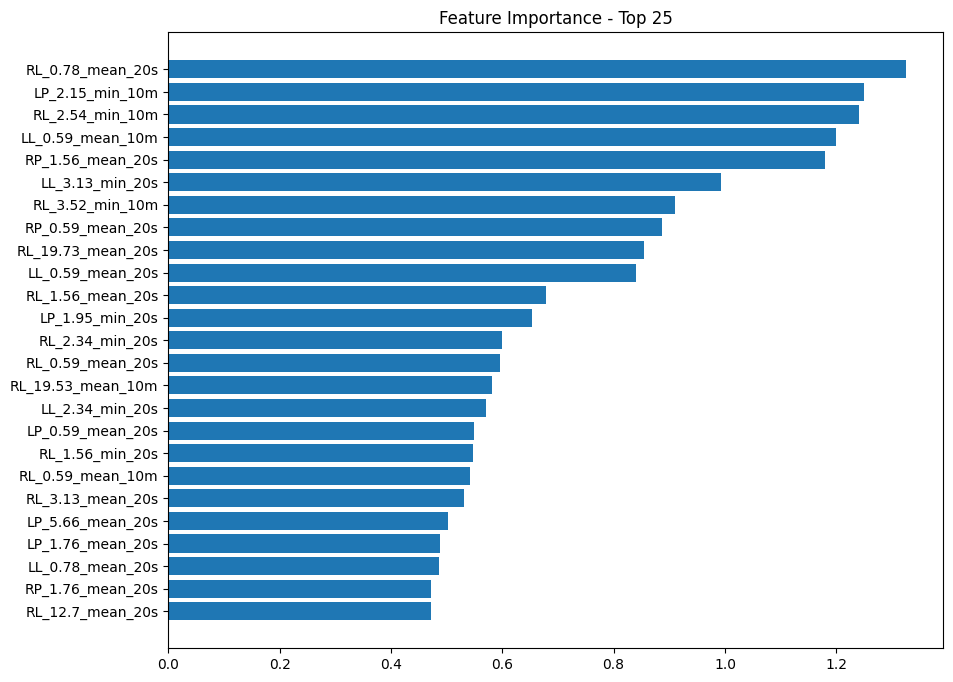

In [18]:
TOP = 25

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], np.array(FEATURES)[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

# CV Score for CatBoost
This is CV score for our CatBoost model.

In [19]:

# sys.path.append('/kaggle/input/kaggle-kl-div')


oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =', cv)

CV Score KL-Div for CatBoost = 0.8315953303553734


# CV Score for Preds 1/6
This is CV score for Kaggle's sample submission.csv which uses equal predictions of 1/6 for all targets.

In [20]:
oof = pd.DataFrame(all_oof.copy())
for c in oof.columns:
    oof[c] = 1/6.
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score for "Use Equal Preds 1/6" =', cv)

CV Score for "Use Equal Preds 1/6" = 1.4563246139800803


# CV Score for EEG_Id Means
This is CV score for current highest scoring public notebook [here][1] which uses train means as predictions.

[1]: https://www.kaggle.com/code/seshurajup/eda-train-csv

In [21]:
all_oof2 = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):
    # print('#'*25)
    # print(f'### Fold {i+1}')

    y_train = train.iloc[train_index][TARGETS].values
    y_valid = train.iloc[valid_index][TARGETS].values

    # print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    # print('#'*25)

    oof = y_valid.copy()
    for j in range(6):
        oof[:, j] = y_train[:, j].mean()
    oof = oof / oof.sum(axis=1, keepdims=True)
    all_oof2.append(oof)

all_oof2 = np.concatenate(all_oof2)

In [22]:
oof = pd.DataFrame(all_oof2.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score for "Use Train Means" =', cv)

CV Score for "Use Train Means" = 1.2641160568651757


# Infer Test and Create Submission CSV
Below we use our 5 CatBoost fold models to infer the test data and create a `submission.csv` file.

In [23]:
test = pd.read_csv(f'{DATA_LOC}test.csv')
print('Test shape', test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [24]:
# FEATURE ENGINEER TEST
PATH2 = f'{DATA_IN}test_spectrograms/'
data = np.zeros((len(test), len(FEATURES)))
for k in range(len(test)):
    row = test.iloc[k]
    s = int(row.spectrogram_id)
    spec = pd.read_parquet(f'{PATH2}{s}.parquet')

    # 10 MINUTE WINDOW FEATURES
    x = np.nanmean(spec.iloc[:, 1:].values, axis=0)
    data[k, :400] = x
    x = np.nanmin(spec.iloc[:, 1:].values, axis=0)
    data[k, 400: 800] = x

    # 20 SECOND WINDOW FEATURES
    x = np.nanmean(spec.iloc[145: 155, 1:].values, axis=0)
    data[k, 800: 1200] = x
    x = np.nanmin(spec.iloc[145: 155, 1:].values, axis=0)
    data[k, 1200: 1600] = x

test[FEATURES] = data
print('New test shape', test.shape)

New test shape (1, 1603)


In [25]:
# INFER CATBOOST ON TEST
preds = []

for i in range(5):
    print(i, ', ', end='')
    model = CatBoostClassifier(task_type='GPU')
    model.load_model(f'{DATA_MEM}catboost/CAT_v{VER}_f{i}.cat')

    test_pool = Pool(data=test[FEATURES]
                     )

    pred = model.predict_proba(test_pool)
    preds.append(pred)
pred = np.mean(preds, axis=0)
print()
print('Test preds shape', pred.shape)

0 , 1 , 2 , 3 , 4 , 
Test preds shape (1, 6)


In [26]:
sub = pd.DataFrame({'eeg_id': test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv(f'{DATA_OUT}submission.csv', index=False)
print('Submissionn shape', sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.123718,0.026667,0.002408,0.149193,0.094427,0.603586


In [27]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:, -6:].sum(axis=1)

0    1.0
dtype: float64